# Jupyter Notebook to help write a CNN Classifier
This is my model project where I will train a custom CNN classifier on PyTorch to classify my images, with what I need and what I don't

## Imports

In [68]:
import os
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from PIL import Image
import torchvision.transforms.functional as TF

%matplotlib inline

In [84]:
# for (dirpath, dirnames, filenames) in os.walk("."):
#         print("Dirpath", dirpath)
#         print("Folder", dirnames)
# #         print(filenames)

Dirpath .
Folder ['Test', 'sorter', 'Train', '.ipynb_checkpoints']
Dirpath ./Test
Folder ['Needed', 'Not Needed']
Dirpath ./Test/Needed
Folder []
Dirpath ./Test/Not Needed
Folder []
Dirpath ./sorter
Folder ['Needed', 'Not Needed']
Dirpath ./sorter/Needed
Folder []
Dirpath ./sorter/Not Needed
Folder []
Dirpath ./Train
Folder ['Needed', 'Not Needed']
Dirpath ./Train/Needed
Folder []
Dirpath ./Train/Not Needed
Folder []
Dirpath ./.ipynb_checkpoints
Folder []


## Transformations

In [85]:
traintransform = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((1000, 1000)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5])
])

testtransform = transforms.Compose([
        transforms.Resize((1000, 1000)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5])
    ])

In [86]:
classes = ["Needed", "Not Needed"]

In [87]:
train_dataset = datasets.ImageFolder("Train", transform=traintransform)
test_dataset = datasets.ImageFolder("Test", transform=testtransform)

In [88]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True)

In [89]:
image, labels = next(iter(trainloader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


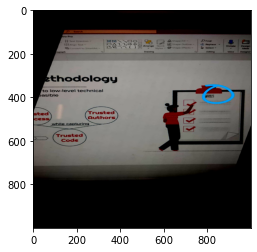

In [90]:
plt.imshow(image[0].permute(1,2,0))

In [91]:
print(labels[0])

tensor(1)


In [48]:
class Net(nn.Module):
    def __init__(self, dropout=0.4):
        super(Net, self).__init__()
        
        self.cnn1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=8, stride=2, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=4, stride=2)
        )
        self.cnn2 = nn.Sequential(
                    nn.Conv2d(16, 64, kernel_size=8, stride=2, padding=2),
                    nn.BatchNorm2d(64),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(kernel_size=4, stride=2)
                )
        self.cnn3 = nn.Sequential(
                    nn.Conv2d(64, 128, kernel_size=8, stride=2, padding=2),
                    nn.BatchNorm2d(128),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(kernel_size=4, stride=2)
                )
        self.cnn4 = nn.Sequential(
                    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=2),
                    nn.BatchNorm2d(256),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(kernel_size=4, stride=2)
                )
        self.fc1 = nn.Linear(256*2*2, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 2)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = self.cnn1(x)
        x = self.cnn2(x)
        x = self.cnn3(x)
        x = self.cnn4(x)
        x = x.view(-1, 256*2*2)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [49]:
model = Net()

In [50]:
criterion = nn.CrossEntropyLoss()

In [51]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [52]:
loaders = {
    'train': trainloader,
    'test' : testloader
}

In [54]:
losses = {'train':[], 'validation':[]}

def train(n_epochs, loaders, model, optimizer, criterion, gpu_available, save_path):
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(tqdm(loaders['train'])):
            # move to GPU
            if gpu_available:
                data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update average training loss
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))

        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(tqdm(loaders['test'])):
            # move to GPU
            if gpu_available:
                data, target = data.cuda(), target.cuda()
            # update the average validation loss
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
            losses['train'].append(train_loss)            
            losses['validation'].append(valid_loss)            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))   
        
        # save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), 'model.pt')
            valid_loss_min = valid_loss            
    # return trained model
    return model


# train the model
model = train(8, loaders, model, optimizer, 
                      criterion, False, 'model.pt')

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 0.537533 	Validation Loss: 1.105168
Validation loss decreased (inf --> 1.105168).  Saving model ...


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 0.377643 	Validation Loss: 0.295593
Validation loss decreased (1.105168 --> 0.295593).  Saving model ...


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 0.355339 	Validation Loss: 0.332975


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 0.463806 	Validation Loss: 0.915075


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 0.342617 	Validation Loss: 0.275839
Validation loss decreased (0.295593 --> 0.275839).  Saving model ...


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 0.264164 	Validation Loss: 0.196581
Validation loss decreased (0.275839 --> 0.196581).  Saving model ...


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 0.315478 	Validation Loss: 0.191204
Validation loss decreased (0.196581 --> 0.191204).  Saving model ...


100%|██████████| 3/3 [00:14<00:00,  4.95s/it]

Epoch: 8 	Training Loss: 0.191571 	Validation Loss: 0.498360


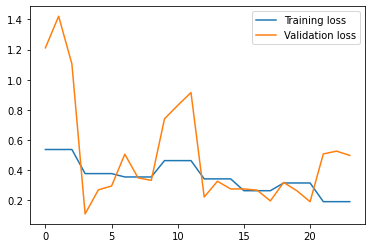

In [56]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

In [57]:
checkpoint = torch.load('model.pt')
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [59]:
def test(loaders, model, criterion, gpu_available):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    class_correct = list(0. for i in range(2))
    class_total = list(0. for i in range(2))
    
    model.eval()
    for batch_idx, (data, target) in enumerate(tqdm(loaders['test'])):
        # move to GPU
        if gpu_available:
            data, target = data.cuda(), target.cuda()
        # compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
        
        # convert output probabilities to predicted class
        _, pred1 = torch.max(output, 1)    
        # compare predictions to true label
        correct_tensor = pred1.eq(target.data.view_as(pred1))
        correct1 = np.squeeze(correct_tensor.numpy()) if not gpu_available else np.squeeze(correct_tensor.cpu().numpy())
        for i in range(2):
            label = target.data[i]
            class_correct[label] += correct1[i].item()
            class_total[label] += 1
            

    for i in range(2):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))
        
            
    print('\nTest Loss: {:.6f}\n'.format(test_loss))
    
    print('\nOverall Test Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders, model, criterion, False)

100%|██████████| 3/3 [00:14<00:00,  4.87s/it]

Accuracy of Needed : 100 %
Accuracy of Not Needed : 100 %

Test Loss: 0.226932


Overall Test Accuracy: 95% (40/42)


In [83]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

# obtain one batch of test images
dataiter = iter(testloader)
images, labels = dataiter.next()
images.numpy()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

In [81]:
from shutil import copyfile
# copyfile(src, dst)


def sort(path, model):
    transform = transforms.Compose([
        transforms.Resize((1000, 1000)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5])
    ])
    filenames = []
    for (dirpath, dirnames, f) in os.walk(path):
        filenames.extend(f)
    
    needed_foldername = os.path.join(path, "Needed")
    not_needed_foldername = os.path.join(path, "Not Needed")
    
    if not os.path.exists(needed_foldername):
        os.mkdir(needed_foldername)
    if not os.path.exists(not_needed_foldername):
        os.mkdir(not_needed_foldername)
    
    for filename in tqdm(filenames):
        if filename == ".DS_Store":
            continue
        image = Image.open(os.path.join(path, filename))
        x = transform(image).unsqueeze(0)
#         x = TF.to_tensor(image)
        output = model(x)
        _, preds_tensor = torch.max(output, 1)
        
        final_class = preds_tensor[0].item()
        
        if final_class == 0:
            copyfile(os.path.join(path, filename), os.path.join(needed_foldername, filename))
        else:
            copyfile(os.path.join(path, filename), os.path.join(not_needed_foldername, filename))
    
    print("Successfully Copied")

        

In [82]:
sort("sorter", model)

100%|██████████| 51/51 [00:16<00:00,  3.02it/s]

Successfully Copied
